In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyse RBS data from Reis et al. 2020

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import re
from common import count_ARN_motifs, count_AAN_motifs, count_ARNn


top_dir = os.path.join('data', '22_analyse_RBS_data_Reis')
fn = os.path.join('data', 'RBS_Calculator', 'sb0c00394_si_002.xlsx')
excel_file = pd.ExcelFile(fn)
name_sheets = excel_file.sheet_names
name_sheets

['Statistics',
 '1014IC',
 'RBS Calculator v1.0',
 'RBS Calculator v1.1',
 'RBS Calculator v2.0',
 'RBS Calculator v2.1',
 'RBS Designer',
 'UTR Designer',
 'EMOPEC']

In [13]:
df = excel_file.parse(name_sheets[5], index_col=0)
# df_aux = excel_file.parse(name_sheets[1], index_col=0)
# df['used_mRNA_sequence'] = df_aux['used_mRNA_sequence']
df_aux = excel_file.parse(name_sheets[4], index_col=0)
df['used_mRNA_sequence'] = df_aux['used_mRNA_sequence']
df['predicted_5pUTR_2.0'] = df_aux['predicted_5pUTR']
df['predicted_CDS_2.0'] = df_aux['predicted_CDS']
df['TIR'] = df_aux['TIR']
# del df_aux

df = df[df['used_mRNA_sequence'].apply(lambda x: type(x) == str)]
df = df[df['predicted_5pUTR_2.0'].apply(lambda x: type(x) == str)]

# df['ARN count'] = df['used_mRNA_sequence'].apply(count_ARN_motifs)
# df['AAN count'] = df['used_mRNA_sequence'].apply(count_AAN_motifs)
df["ARN count (5' UTR)"] = df['predicted_UTR'].apply(count_ARN_motifs)
df["AAN count (5' UTR)"] = df['predicted_UTR'].apply(count_AAN_motifs)
df["ARNn count (5' UTR)"] = df['predicted_UTR'].apply(count_ARNn)

df["log(yError)"] = np.log10(df["yError"])  # avoid log(0)

print("\nShape of dataframe:", df.shape)


Shape of dataframe: (984, 44)


In [15]:
df

,dG_total,dG_mRNA,dG_mRNA_rRNA,dG_spacing,dG_start,dG_standby,dG_distortion,dG_sliding,dG_unfolding,dG_SD_aSD,...,ddG_standby,Percent_Folded_in_RBS_Kfold,used_mRNA_sequence,predicted_5pUTR_2.0,predicted_CDS_2.0,TIR,ARN count (5' UTR),AAN count (5' UTR),ARNn count (5' UTR),log(yError)
0,-0.247351,-31.160000,-36.301351,0.000000,-2.76,7.83440,7.83440,0.0,0.00,-13.151352,...,-23.15,0.249,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCATAA...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCATAA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,3658.739959,5,3,1,0.052677
1,-1.972352,-30.490000,-36.301351,0.000000,-2.76,6.77940,6.77940,0.0,0.00,-13.151352,...,-23.15,0.243,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAATA...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAATA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,8063.178500,5,3,1,0.114572
2,-3.590951,-29.850000,-36.301351,0.000000,-2.76,5.80080,5.80080,0.0,0.00,-13.151352,...,-23.15,0.206,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAT...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAT...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,13106.213247,6,4,1,-0.065173
3,-5.498951,-29.670000,-36.301351,0.000000,-2.76,4.07280,4.07280,0.0,0.00,-13.151352,...,0.00,0.233,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAA...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,28545.070272,6,4,1,0.062744
4,-7.517951,-29.670000,-36.301351,0.000000,-2.76,2.05380,2.05380,0.0,0.00,-13.151352,...,0.00,0.198,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAA...,TCTAGAGGCCGACGCAAGCCCATATCGGGGCTTCCGTCGGCCAAAA...,ATGgcGAGCTCtgaagacgttatcaaagagttcatgcgtttcaaag...,70895.376747,7,5,2,0.095553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,1.851247,-3.390000,-1.316979,0.005326,-2.76,2.65040,2.65040,0.0,0.00,-1.316979,...,0.00,0.000,ATGTTTCAACCAGAAAGAACAATAACATGCTACCAAAAGCCGCCCG...,ATGtttcaaccagaaagaacaataac,ATGCTACCAAAAGCCGCCCGCATTCCCCACGCCATGACGCTTCATG...,782.726528,5,4,3,-0.319384
1010,4.116920,-26.629999,-23.426979,0.288000,-2.76,3.69000,0.00000,0.0,3.69,-5.806979,...,-1.02,0.000,ATGATAATAATTCTTAGTATTAATTCGGCAATCTGATTCTACTCCC...,ATGataataattcttagtattaattcggcaatcTGAttctactccc...,ATGTCTCATACAATCCGTGATAAACAGAAACTGAAAGCGCGTGCCG...,241.522419,3,1,1,-1.211720
1011,3.428447,-10.750000,-8.306979,0.005326,-2.76,4.07280,4.07280,0.0,0.00,-5.686979,...,0.00,0.000,AATGAAATTCAGCAGGATCACATTATGACCTTTCGCAATTGTGTCG...,AATGaaattcagcaggatcacatt,ATGACCTTTCGCAATTGTGTCGCCGTCGATCTCGGCGCATCCAGTG...,943.882884,3,1,2,-0.090518
1012,8.237871,-12.980000,-8.626979,0.288000,1.81,2.12215,1.30215,0.0,0.82,-5.886979,...,-1.44,0.000,AATGACTAACTATCAGTAGCGTTATCCCTATTTCTGGAGATATTCC...,AATGactaactatcagTAGcgttatccctatttctggagatattcct,TTGATCAACGTTCTACTTGTTGATGACCACGAACTGGTGCGCGCAG...,206.277331,3,1,1,0.801998


# ARN motifs vs. predicted DG

<Axes: xlabel="ARNn count (5' UTR)", ylabel='dG_total'>

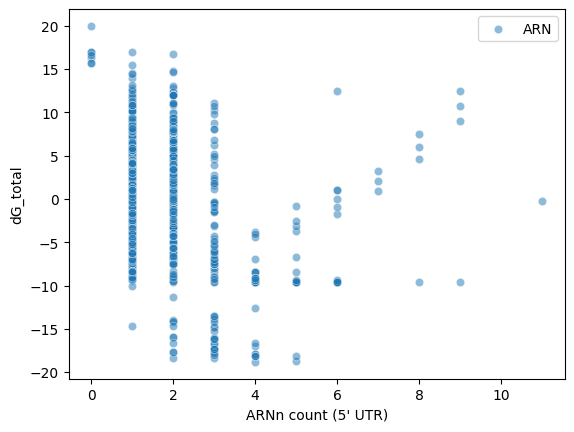

In [16]:
sns.scatterplot(data=df, x="ARNn count (5' UTR)", y='dG_total', label='ARN', alpha=0.5)
# sns.scatterplot(data=df, x="AAN count (5' UTR)", y='dG_total', label='AAN', alpha=0.5)

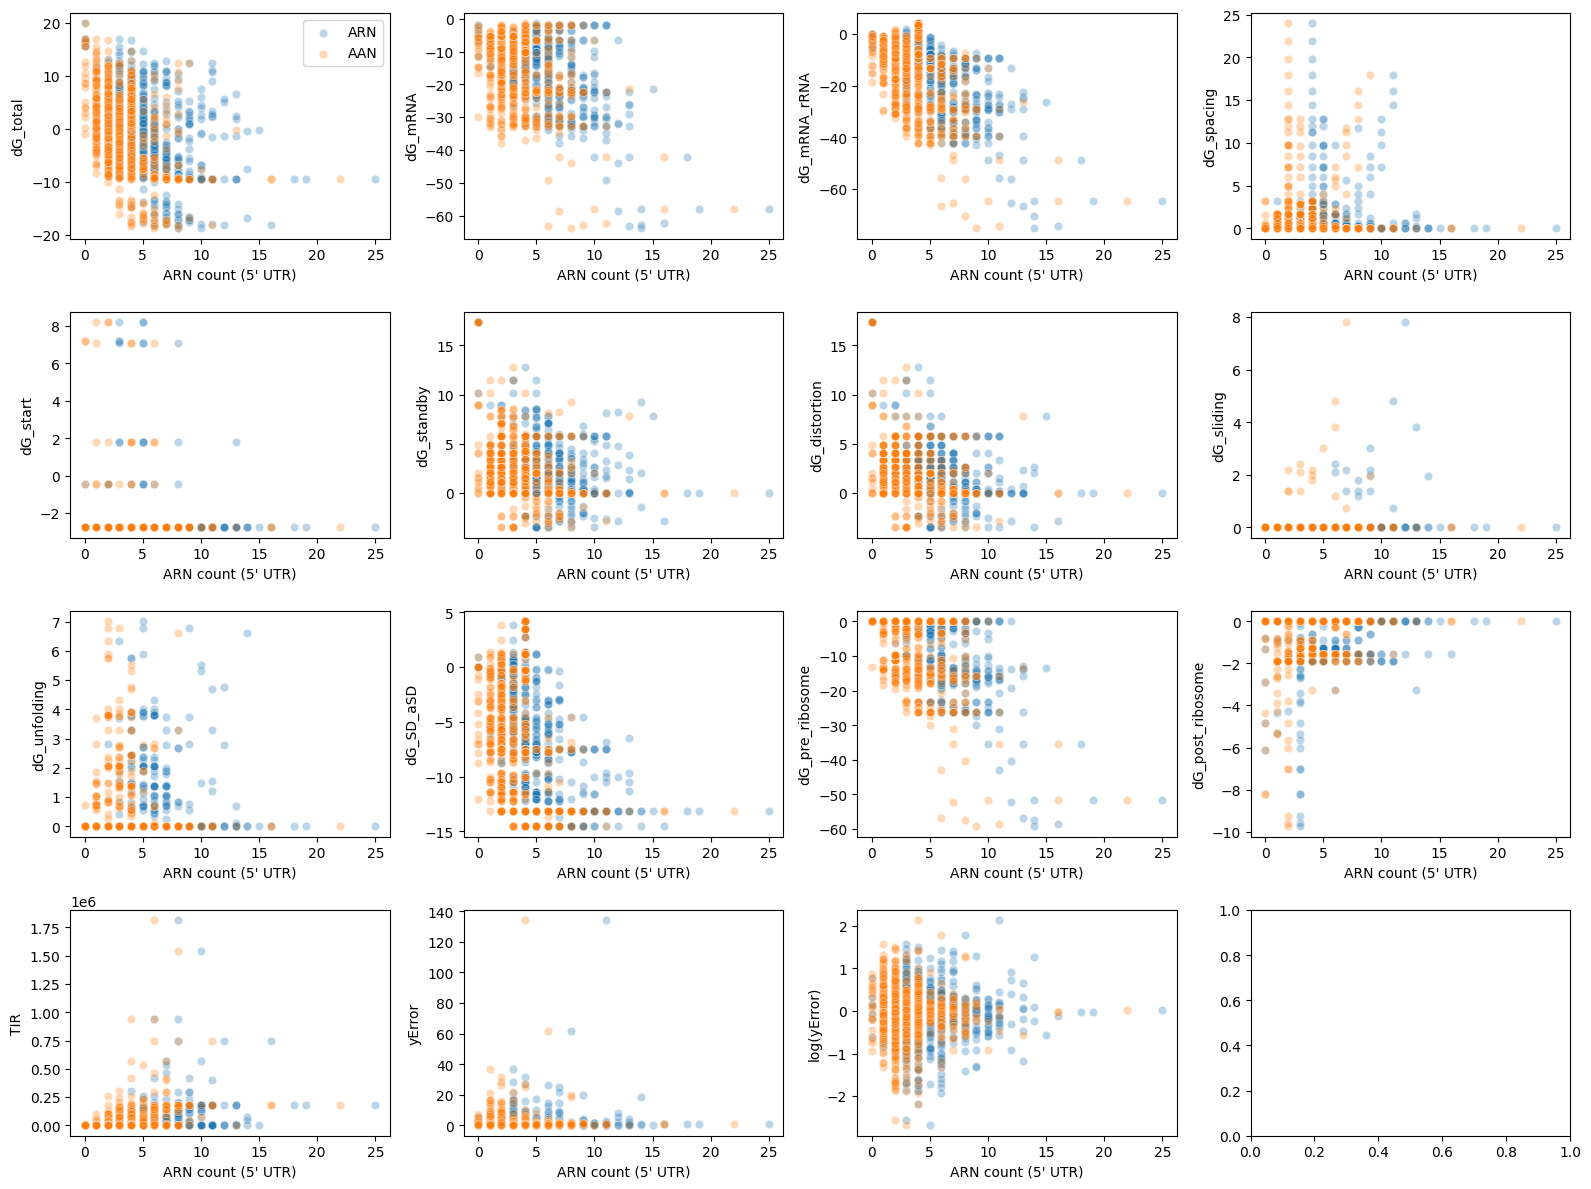

In [17]:
cols_dg = [col for col in df.columns if col.startswith('dG')] + [
    'TIR', 'yError', 'log(yError)']
nrows = int(np.ceil(np.sqrt(len(cols_dg))))
ncols = int(np.ceil(len(cols_dg) / nrows))
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
for i, col in enumerate(cols_dg):
    sns.scatterplot(df, x="ARN count (5' UTR)", y=col, label='ARN', # palette='coolwarm', 
                    alpha=0.3, ax=axs.flat[i], legend=True if i==0 else False)
    sns.scatterplot(df, x="AAN count (5' UTR)", y=col, label='AAN', # palette='coolwarm', 
                    alpha=0.3, ax=axs.flat[i], legend=True if i==0 else False)
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'RBS_DG_vs_ARN_count.png'), dpi=300)

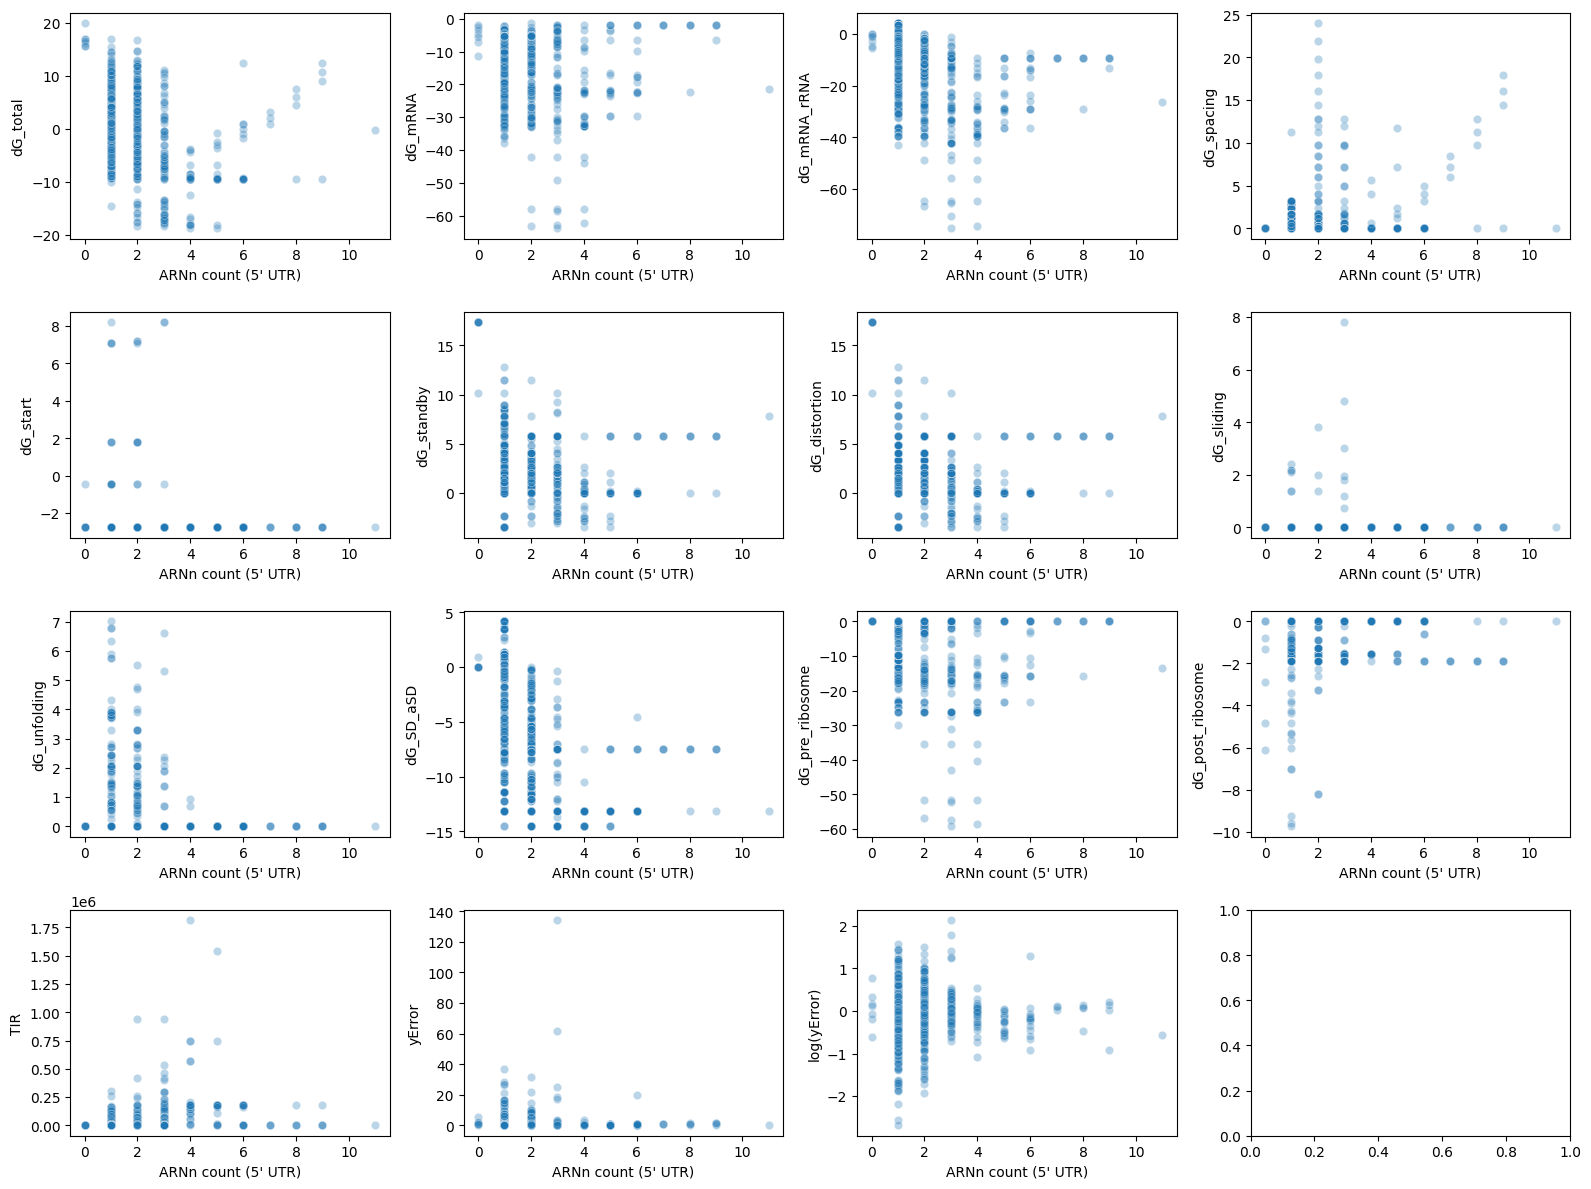

In [18]:
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
for i, col in enumerate(cols_dg):
    sns.scatterplot(df, x="ARNn count (5' UTR)", y=col,
                    alpha=0.3, ax=axs.flat[i], legend=True if i==0 else False)
plt.tight_layout()
plt.savefig(os.path.join(top_dir, 'RBS_DG_vs_ARNn.png'), dpi=300)

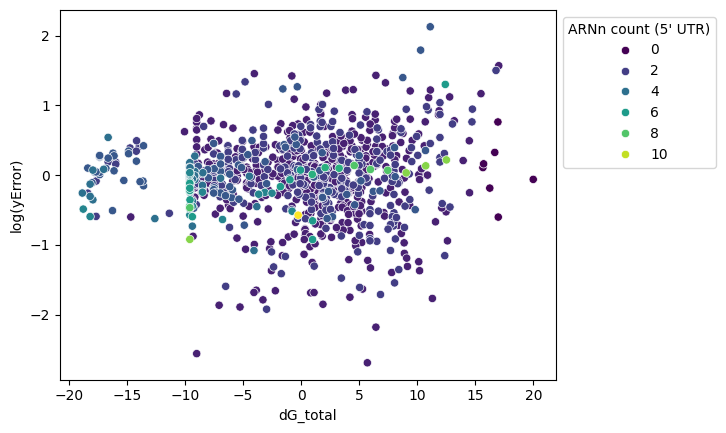

In [34]:
df['log(TIR)'] = np.log10(df['TIR'] + 1)
g = sns.scatterplot(data=df.sort_values("ARNn count (5' UTR)"), x="dG_total", y='log(yError)', hue="ARNn count (5' UTR)", palette='viridis', alpha=1) #0.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))